In [23]:
from cmath import nan
from data import loader
import pandas as pd
import numpy as np
import datetime
import pdb

In [24]:
d1 = loader.get_global_case_and_deaths_time_series_data()
oxford_data = pd.read_csv("owid-covid-data.csv")
names = ["case_count", "death_count"]
first_date = datetime.date(2020, 1, 22)

#### 1. Transform Oxford Data to JHU format

In [25]:
oxford_dfs = []
for df_idx, df in enumerate(d1):
    total_days = np.array(["Day" in x for x in df.columns]).sum()
    columns = ["Day " + str(day) for day in range(total_days)]
    columns.insert(0, "Admin0")
    oxford_df = []
    for base_country in df["Admin0"]:
        curr_df = [base_country]
        for day in range(total_days):
            date = first_date + datetime.timedelta(days=day)
            if df_idx == 0 and oxford_data.loc[(oxford_data["location"] == base_country) & (oxford_data["date"] == date.isoformat())]["new_cases"].empty or \
                df_idx == 1 and oxford_data.loc[(oxford_data["location"] == base_country) & (oxford_data["date"] == date.isoformat())]["new_deaths"].empty:
                curr_df.append(nan)
            else:
                if df_idx == 0:
                    curr_df.append(float(oxford_data.loc[(oxford_data["location"] == base_country) & (oxford_data["date"] == date.isoformat())]["new_cases"]))
                else:
                    curr_df.append(float(oxford_data.loc[(oxford_data["location"] == base_country) & (oxford_data["date"] == date.isoformat())]["new_deaths"]))
        if oxford_data["location"].str.contains(base_country).any():
            oxford_df.append(curr_df)
    oxford_dfs.append(pd.DataFrame(oxford_df, columns=columns))
names = ["case_count", "death_count"]
for idx, oxford_df in enumerate(oxford_dfs):
    oxford_df.to_csv("data/oxford_in_JHU_format_" + names[idx] + ".csv")

/home/kaiser/.local/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


#### 2. Find Mismatch country names and clean up the transformed data

In [26]:
# Find the countries in oxford but not in JHU
country_not_in_JHU = set()
for country in oxford_data["location"]:
    if not d1[0]["Admin0"].str.contains(country).any():
        country_not_in_JHU.add(country)
print("Countries in oxford but not in JHU: ", country_not_in_JHU)

# Find the countries in JHU but not in Oxford
country_not_in_Oxford = set()
for country in d1[0]["Admin0"]:
    if not oxford_data["location"].str.contains(country).any():
        country_not_in_Oxford.add(country)
print("Countries in JHU but not in Oxford: ", country_not_in_Oxford)

JHU_Country_to_Oxford = {'US': 'United States', 'Congo (Kinshasa)': 'Democratic Republic of Congo', 
'Czech Republic': 'Czechia', 'Cabo Verde': 'Cape Verde', 'West Bank and Gaza': 'Palestine', 'Burma': 'Myanmar'}

Countries in oxford but not in JHU:  {'Falkland Islands', 'European Union', 'Oceania', 'Montserrat', 'Cape Verde', 'Bonaire Sint Eustatius and Saba', 'Czechia', 'Wallis and Futuna', 'Northern Cyprus', 'South America', 'Cook Islands', 'Tokelau', 'Jersey', 'Myanmar', 'Hong Kong', 'Isle of Man', 'International', 'Macao', 'North America', 'Cayman Islands', 'Nauru', 'Turkmenistan', 'Gibraltar', 'Pitcairn', 'Curacao', 'Asia', 'British Virgin Islands', 'Democratic Republic of Congo', 'French Polynesia', 'Micronesia (country)', 'Saint Helena', 'New Caledonia', 'Europe', 'United States', 'Sint Maarten (Dutch part)', 'Niue', 'Anguilla', 'Faeroe Islands', 'Tuvalu', 'Greenland', 'Palestine', 'World', 'Turks and Caicos Islands', 'Bermuda', 'Aruba'}
Countries in JHU but not in Oxford:  {'US', 'West Bank and Gaza', 'Burma', 'Czech Republic', 'Congo (Kinshasa)', 'Vatican City', 'Cabo Verde', 'Timor-Leste', 'Congo (Brazzaville)'}


**Countries/Territories in oxford but not in JHU:**  
{'Faeroe Islands', 'Nauru', 'Turkmenistan', 'Isle of Man', 'Montserrat', 
'Aruba', 'Saint Helena', 'Greenland', 'French Polynesia', 
'Micronesia (country)', 'Curacao', , 'Bermuda', 'Wallis and Futuna', 
'Anguilla', 'Gibraltar', 'Cayman Islands', 'Sint Maarten (Dutch part)', 
, 'Falkland Islands', 'Northern Cyprus', '
Bonaire Sint Eustatius and Saba', 'British Virgin Islands', 'Cook Islands', 
 'Niue', 'Hong Kong', 'Tuvalu', 'New Caledonia', 'Macao',
'Pitcairn', 'Jersey', 'Tokelau', 
'Turks and Caicos Islands'}

**Countries/Territories in JHU but not in Oxford:**  
{'Congo (Brazzaville)', 'Timor-Leste', 'Vatican City'}

In [27]:
JHU_Country_to_Oxford = {'US': 'United States', 'Congo (Kinshasa)': 'Democratic Republic of Congo', 
'Czech Republic': 'Czechia', 'Cabo Verde': 'Cape Verde', 'West Bank and Gaza': 'Palestine', 'Burma': 'Myanmar'}

oxford_case = pd.read_csv("data/oxford_in_JHU_format_case_count.csv")
oxford_death = pd.read_csv("data/oxford_in_JHU_format_death_count.csv")
oxford_dfs = [oxford_case, oxford_death]

In [28]:
# Add the clean countries to oxford data, too
for df_idx, df in enumerate(d1):
    total_days = np.array(["Day" in x for x in df.columns]).sum()
    for country in JHU_Country_to_Oxford.keys():
        ctry_df = {"Admin0": JHU_Country_to_Oxford[country]}
        for day in range(total_days):
            date = first_date + datetime.timedelta(days=day)
            if df_idx == 0:
                ctry_df["Day " + str(day)] = float(oxford_data.loc[(oxford_data["location"] == JHU_Country_to_Oxford[country]) & (oxford_data["date"] == date.isoformat())]["new_cases"]) if not oxford_data.loc[(oxford_data["location"] == JHU_Country_to_Oxford[country]) & (oxford_data["date"] == date.isoformat())]["new_cases"].empty else nan
            else:
                ctry_df["Day " + str(day)] = float(oxford_data.loc[(oxford_data["location"] == JHU_Country_to_Oxford[country]) & (oxford_data["date"] == date.isoformat())]["new_deaths"]) if not oxford_data.loc[(oxford_data["location"] == JHU_Country_to_Oxford[country]) & (oxford_data["date"] == date.isoformat())]["new_deaths"].empty else nan
        oxford_dfs[df_idx] = oxford_dfs[df_idx].append(ctry_df, ignore_index=True)

for idx, oxford_df in enumerate(oxford_dfs):
    oxford_df.to_csv("data/oxford_in_JHU_format_" + names[idx] + ".csv")

#### 3. Compare the difference between Oxford and JHU data

In [29]:
oxford_case = pd.read_csv("data/oxford_in_JHU_format_case_count.csv")
oxford_death = pd.read_csv("data/oxford_in_JHU_format_death_count.csv")
oxford_dfs = [oxford_case, oxford_death]

In [50]:
import math
first_date = datetime.date(2020, 1, 22)
total_days = np.array(["Day" in x for x in d1[0].columns]).sum()

# For each country, get difference in days, and average difference througout the days, both count and not count missing days
diff_dfs_count_missing = []
diff_dfs_not_count_missing = []
for dx_idx, df in enumerate(d1):
    diff_df_count = []
    diff_df_not_count = []
    for jhu_country in df["Admin0"]:
        if oxford_dfs[df_idx]["Admin0"].str.contains(jhu_country).any():
            ctry_df_count_missing = {"Admin0": jhu_country}
            ctry_df_not_count_missing = {"Admin0": jhu_country}
            for day in range(total_days):
                if jhu_country not in JHU_Country_to_Oxford:
                    oxford_count = oxford_dfs[df_idx].loc[oxford_dfs[df_idx]["Admin0"] == jhu_country]["Day " + str(day)].values[0]
                else:
                    oxford_count = oxford_dfs[df_idx].loc[oxford_dfs[df_idx]["Admin0"] == JHU_Country_to_Oxford[jhu_country]]["Day " + str(day)].values[0]
                
                if math.isnan(oxford_count):
                    ctry_df_count_missing["Day " + str(day)] = df.loc[df["Admin0"] == jhu_country]["Day " + str(day)].values[0]
                    ctry_df_not_count_missing["Day " + str(day)] = 0
                else:
                    ctry_df_count_missing["Day " + str(day)] = df.loc[df["Admin0"] == jhu_country]["Day " + str(day)].values[0] - oxford_count
                    ctry_df_not_count_missing["Day " + str(day)] = df.loc[df["Admin0"] == jhu_country]["Day " + str(day)].values[0] - oxford_count
            diff_df_count.append(ctry_df_count_missing)
            diff_df_not_count.append(ctry_df_not_count_missing)
    diff_dfs_not_count_missing.append(pd.DataFrame(diff_df_not_count))
    diff_dfs_count_missing.append(pd.DataFrame(diff_df_count))
print(diff_dfs_not_count_missing)
print(diff_dfs_count_missing)

/home/kaiser/.local/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


[             Admin0  Day 0   Day 1   Day 2   Day 3    Day 4    Day 5    Day 6  \
0       Afghanistan      0    0.00    0.00    0.00     0.00     0.00     0.00   
1           Albania      0    0.00    0.00    0.00     0.00     0.00     0.00   
2           Algeria      0    0.00    0.00    0.00     0.00     0.00     0.00   
3           Andorra      0    0.00    0.00    0.00     0.00     0.00     0.00   
4            Angola      0    0.00    0.00    0.00     0.00     0.00     0.00   
..              ...    ...     ...     ...     ...      ...      ...      ...   
180        Guernsey      0    0.00    0.00    0.00     0.00     0.00     0.00   
181  United Kingdom      0    0.00    0.00    0.00     0.00     0.00     0.00   
182          Canada      0    0.00    0.00    0.00     0.00     0.00     0.00   
183           China      0  658.02  754.72  878.83  1047.27  1228.41  1430.15   
184        Malaysia      0    0.00    0.00    0.00     0.00     0.00     0.00   

       Day 7    Day 8  ...

Average difference over countries and over days:  1458.7119618367467


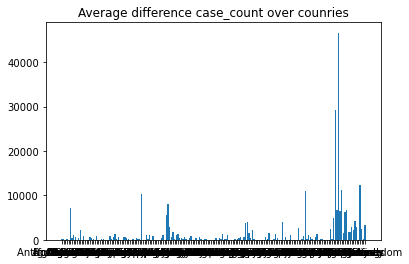

Average difference over countries and over days:  0.26313817523056665


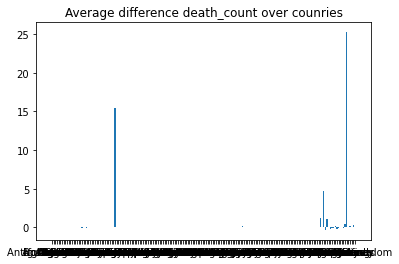

In [65]:
import matplotlib.pyplot as plt

differences = []
averages_collec = []
for df_idx, df in enumerate(diff_dfs_not_count_missing):
    countries = df["Admin0"].tolist()
    diff = df.iloc[len(df.columns) - total_days:, 1:].to_numpy(na_value = 0)
    xtick = [str(i) for i in range(diff.shape[1])]
    averages = np.average(diff, axis=1)
    averages_collec.append(averages)
    print("Average difference over countries and over days: ", np.average(averages))
    x = np.arange(averages.shape[0])
    plt.bar(x, height=averages)
    plt.xticks(x, countries)
    plt.title("Average difference " + names[df_idx] + " over counries")
    plt.show()
    # for idx, row in enumerate(diff):
    #     x = np.arange(row.shape[0])
    #     plt.bar(x, height=row)
    #     plt.xticks(x, xtick)
    #     plt.title("Difference for " + names[df_idx] + " counts without counting missing")
    #     plt.show()
        


#### Plot the difference grouped by continent

In [62]:
def load_country_names_by_countinent(continent):
    with open("data/territory_names/" + continent + "_countries.txt", "r") as f:
        country_names = [line.rstrip() for line in f]
    return country_names

Average difference of case_count in Africa 602.0705347593581


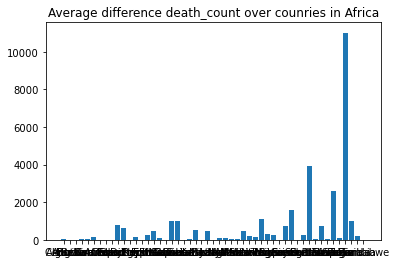

Average difference of death_count in Africa 0.0015472910927456461


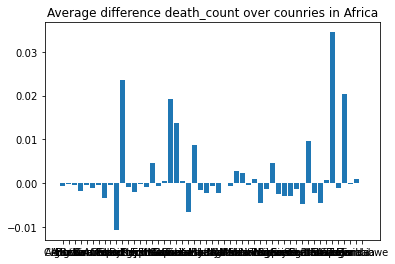

Average difference of case_count in Europe 1553.673699986882


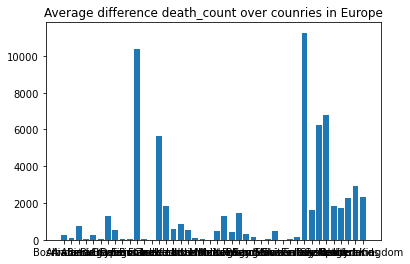

Average difference of death_count in Europe 0.5992204512659064


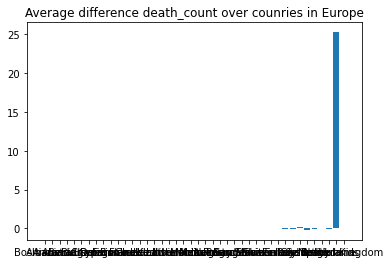

Average difference of case_count in SouthAmerica 6396.769792011017


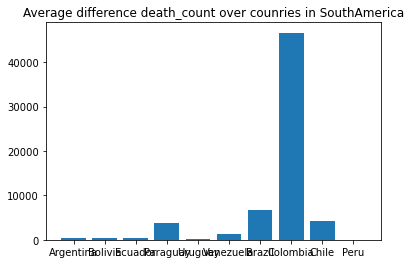

Average difference of death_count in SouthAmerica 0.17015289256198335


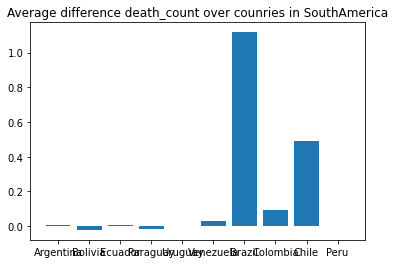

Average difference of case_count in NorthAmerica 1995.1673766591534


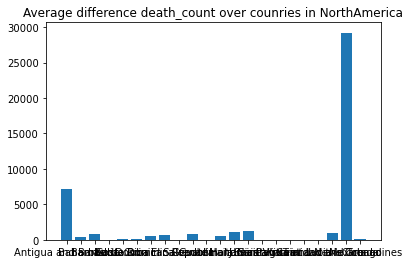

Average difference of death_count in NorthAmerica 0.6997965189080891


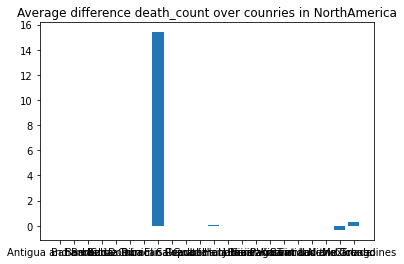

In [67]:
continents = {"NorthAmerica", "SouthAmerica", "Africa", "Europe"}

for continent in continents:
    cont_countries = load_country_names_by_countinent(continent)
    # Retrieve the case count and death count for corresponding countries
    cont_countries_clean = []
    for idx, averages in enumerate(averages_collec):
        country_indices = []
        for country in cont_countries:
            if country in countries:
                country_indices.append(countries.index(country))
                cont_countries_clean.append(country)
        country_avg = averages[country_indices]
        print("Average difference of " + names[idx] + " in " + continent, np.average(country_avg))
        x = np.arange(country_avg.shape[0])
        plt.bar(x, height=country_avg)
        plt.xticks(x, cont_countries_clean)
        plt.title("Average difference " + names[df_idx] + " over counries in " + continent)
        plt.show()
        

